# Prelim Analysis


In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

## Collect all the initial Feedback

<ul>
 <li>Loop through all the files</li>
 <li>Grab the responses for the survey</li>
 <li>Add them to a list or dictionary</li>
</ul>

In [ ]:
import os

folder = os.listdir('JatosExperiment_Results')

feedbackSummary = []

for file_name in folder:
    df = pd.read_csv(f'JatosExperiment_Results/{file_name}')

    flag = 'survey-text'

    index = df.loc[df['trial_type'] == flag, 'response'].index #grab the index of the row 
    feedback_Object = df.loc[df['trial_type'] == flag, 'response'].to_dict() #this returns a dict with {index of row: contents of row}
    feedback_dictionary = feedback_Object[index[0]] #extract just the dictionary, but it is still a string

    feedback = json.loads(feedback_dictionary)

    feedbackSummary.append(feedback)

with open("Feedback_Summary.txt", 'w') as file:
    json.dump(feedbackSummary, file, indent=4)


    

## Analysing Preferences for monsters for each participant  - First Block
 

In [2]:
#function to calculate the optimal subplot size
def calc_subplots(n_datasets,ncolumns):
    subplots = n_datasets
    columns = ncolumns

    rows = subplots // columns

    if subplots % columns != 0:
        rows +=1 

    return (rows, columns)


In [3]:

imagesPath = 'C:\Master Biosciences\Hiwi Job Heidelberg\monsters'
imagesList = [image for image in os.listdir(imagesPath) if image.endswith('.png')]


Text(0.5, 0.98, 'Preferences First Block \nNumber of times each monster was chosen per participant')

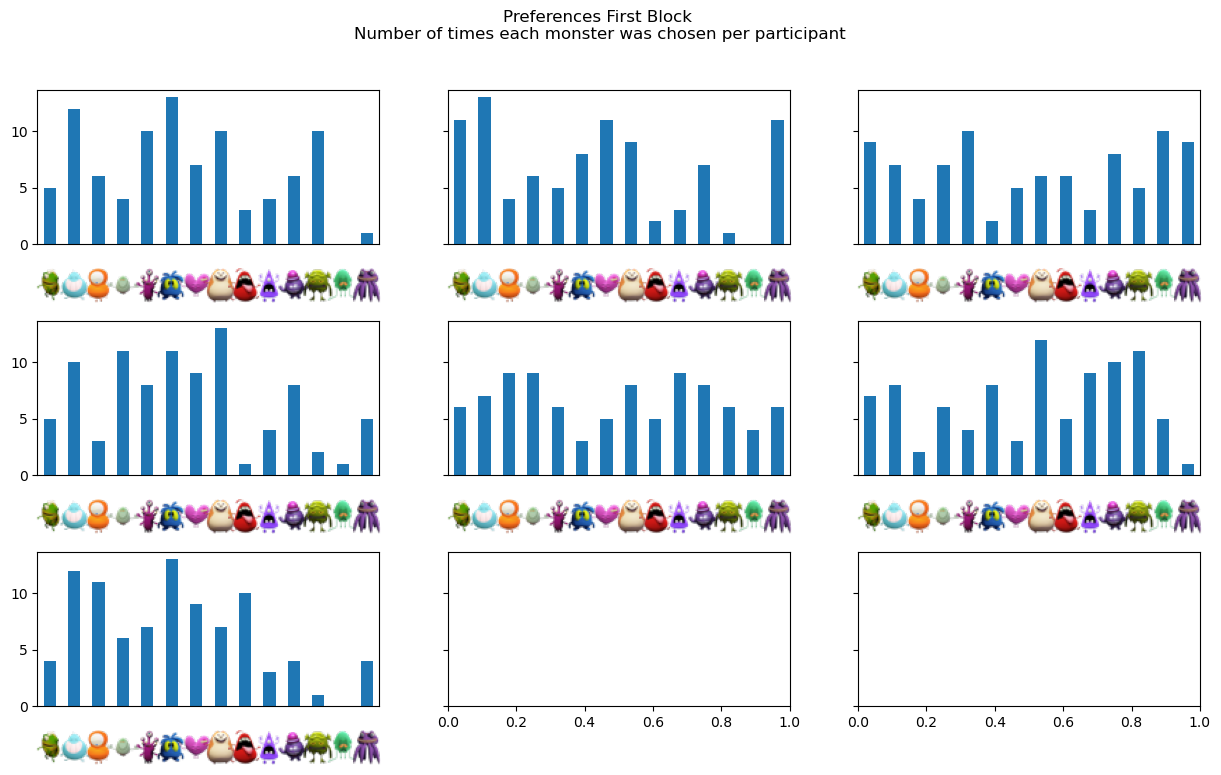

In [ ]:

folder = os.listdir('JatosExperiment_Results')
n_datasets = len(folder)
columns = 3
subplot = calc_subplots(n_datasets, columns)
figsize = (15,8)


fig, axes = plt.subplots( subplot[0], subplot[1], figsize = figsize, sharey=True)
#we need a consistent xtick labels across all the subplots, so we need to specify the order
imagesPath = 'C:\Master Biosciences\Hiwi Job Heidelberg\monsters'
imagesList = [image for image in os.listdir(imagesPath) if image.endswith('.png')]


for index, file_name in enumerate(folder):
    df = pd.read_csv(f'JatosExperiment_Results/{file_name}')

    colstodrop = ['stimulus', 'url','success','plugin_version','view_history']

    firstBlock = df.loc[(df['trial_index'] >= 4) & (df['trial_index'] <=94)]
    firstBlock = firstBlock.drop(colstodrop, axis=1)

    #create a new column which will store the monster chosen by participant
    insert_position = firstBlock.columns.get_loc('rightstim') + 1 #i want the chosen monster column to be inserted after the rightstim column
    firstBlock.insert(insert_position, 'Chosen_Monster', 0)

    #assign the value of the chosen monster based off the key press
    firstBlock.loc[firstBlock['response'] == "ArrowRight", 'Chosen_Monster'] = firstBlock['rightstim']
    firstBlock.loc[firstBlock['response'] == "ArrowLeft", 'Chosen_Monster'] = firstBlock['leftstim']

    #quick plot of the counts of the chosen monsters per participant
    firstBlock['Chosen_Monster'].value_counts().reindex(imagesList).plot(kind='bar', ax = axes.flatten()[index])


    #Replacing the image names with their thumbnails
    axes.flatten()[index].set_xticks([])

    for j, image_path in enumerate(imagesList):
        ##logic
        #load image
        #get thumbnail from image object
        #create a numpy array for using np.asarray as OffsetImage works with numpy arrays
        #create an OffsetImage object (this makes it possible to move the thumbnail to wherever we want) == thumbnail
        #use Annotationbox to place it at (j,0) and then offset it by -30 pts so they appear below the xaxis

        image = Image.open(f"../monsters/{image_path}")
        image.thumbnail((25,25))
        array_image = np.asarray(image)
        thumbnail = OffsetImage(array_image, zoom=1)
        xtick_image = AnnotationBbox(thumbnail, (j,0), xybox = (0,-30), frameon=False,
                                     xycoords='data', boxcoords="offset points", pad=0)
        axes.flatten()[index].add_artist(xtick_image)


plt.subplots_adjust(hspace= 0.5)
fig.suptitle(f'Preferences First Block \nNumber of times each monster was chosen per participant')




## Visualizing sorting arrangements in the Second Block for each participant

## First lets create a workable format with the data:
<h3>Logic</h3>
 <ul>
 <li>Seperate the second block from the main dataframe leaving only the columns we need.</li>
 <li>Extract all the unique sorting criteria</li>
 <li>Based off each criteria, get the final locations of all the monsters (returns a string)</li>
 <li>Then convert the string to a json object</li>
 <li>From the json extract the order of monsters for each criteria and positions of those monsters into separate arrays</li>
    <ul>
        <li>I am splitting the monster order and their respective positions into separate arrays so it makes <br> plotting easier, especially when overlaying the images on top of the points</li>
    </ul>

<li>Create a subplots for each criteria. Use helper function to create an optimal subplot arrangement.</li>
<li>Then for each participant create a subplot with how the monsters are arranged according to their respective criteria
 
 </ul>

In [6]:
df

secondBlock = df.loc[df['trial_type'] == 'free-sort']
colstodrop = ['stimulus', 'url','success','plugin_version','view_history', 'stimulus',
              'response', 'leftstim', 'rightstim']
secondBlock = secondBlock.drop(colstodrop, axis=1)
sorting_criteria = sorted(secondBlock['sort_criteria'].unique())

sorted_monsters = {} #dictionary to hold the final positions of monsters in the order they were sorted based off criteria
sorted_positions = {} #dictionary to hold the final coordinates of the monsters based off criteria


for criteria in sorting_criteria:

    #grab the value in the respective row and column and convert it to a json so we can work with it
    value = secondBlock.loc[secondBlock['sort_criteria']==criteria, 'final_locations'].squeeze()
    value = json.loads(value)

    monster_order = []
    monster_positions = []
    for i in value:
        monster = i['src']
        monster_order.append(monster)

        x, y = i['x'], i['y']
        coordinates = (x,y)
        monster_positions.append(coordinates)
    
    sorted_monsters[criteria] = monster_order
    sorted_positions[criteria] = monster_positions




Text(0.5, 1.0, 'Cuteness')

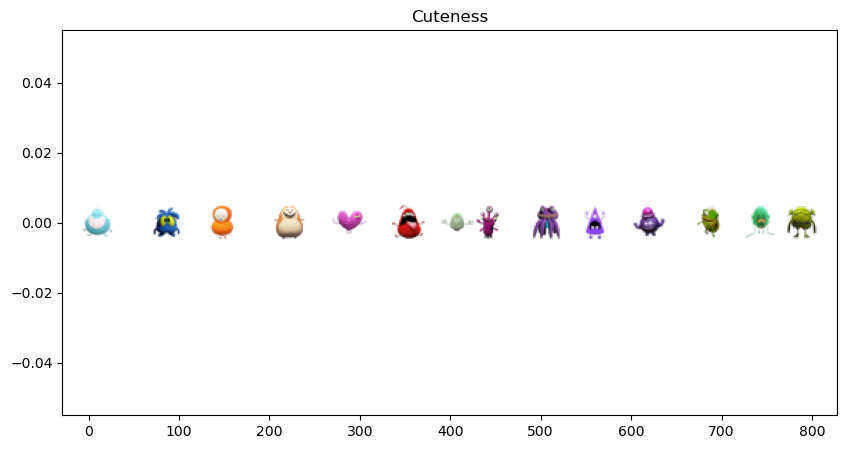

In [13]:

figsize = (10,5)

fig, axes = plt.subplots(figsize=figsize)

positions = sorted_positions['Cuteness']
m = sorted_monsters['Cuteness']
for (x,y), image_path in zip(positions,m):
    y = y*0 #this ensures that the original y coordinates are reset to zero so we can visualize all of them on a line
    axes.scatter(x,y)

    img = Image.open(f"../{image_path}")
    img.thumbnail((25,25))
    img_array = np.asarray(img)

    imagebox = OffsetImage(img_array,zoom=1)
    monster = AnnotationBbox(imagebox, (x,y), frameon=False)
    axes.add_artist(monster)

plt.title('Cuteness')

<h1>Data Processing for statistical analyses</h1>

<h2>Setting up the data for a logistic regression</h2>
<h3>Questions we are trying to answer in simple words:</h3>
    <ul>
    <li>Which criteria do participants use to choose a particular monster in the first block?</li>
    <li>How strong these criterias play a role in the choices of different participants? Does for example cuteness influence one participant more strongly than the other?</li>
    </ul>

<p>We shall use a logistic regression to see how likely a participant is going to choose the left monster based off the different criteria. We use the sorted positions of the monsters for each criteria, from the second block, as a "rating". For example: based off how the monsters are arranged according to cuteness, in every trial we see how any two presented monsters differ in their magnitudes of cuteness, as perceived by the participant. We do this by calculating the difference in the x positions of the left monster and right monster, and then using this difference as a predictor in the logistic regression model. The same applies to all the other criteria and these go into the model as well. We should in the end have 6 predictors (based off the criteria) going into the model which will be then used to see which one of these influences the likelihood of choosing the left monster.</p>

<h2>Logic</h2>
<h3>Code here will be for a single participant (code will be extended for more data below)</h3>
<p>Dependent variable: Chosen Monster.
Independent variable (predictors) : Cuteness, Emotions, Size, Shape, Personal Preference, Colour </p>
    <ul>
    <li>For the dependent variable (Chosen Monster): We code left as 1 and right as 0.</li>
        <ul>
        <li>Create an empty column "Chosen Monster"</li> ✅
        <li>Based off the response column, code 1 in the Chosen Monster column if response == ArrowLeft and code 0 if response ==ArrowRight. </li>✅
        </ul>
    <li>For every participant, we run a logistic regression and see beta coefficients for the predictors.</li>
        <ul>
            <li>Create a main dataframe. Drop all the unwanted columns</li>
            <li>Extract the sorted positions for each monster for all the six criteria, just x values.</li>
            <li>Make a dataframe where the columns are the criteria (which hold the x values of the monsters from the origin)</li>
            <li>In our main dataframe, for every trial (pairing of monsters), we extract the x values for each criteria for the corresponding monsters and make a column each for left and right.</li>
            <li>Then we just add new columns where we have the difference values for each pair on each trial, for each criterium</li>
            <li>Optionally we can drop the response column, the left and right value columns for the criteria, just to keep the main dataframe less convoluted.</li>
            <li>Optionally we can provide participant ids for the participants and concatenate the main dataframes in the end? Need to double check this.</li>
        </ul>
    </ul>

In [ ]:
main_df = pd.read_csv(r"C:\Master Biosciences\Hiwi Job Heidelberg\Data_Analysis\JatosExperiment_Results\jatos_results_data_20250520083350.csv")
colstodrop = ['stimulus', 'url','success','plugin_version','view_history','init_locations', 'question_order', 'moves']
main_df = main_df.drop(colstodrop, axis=1)
main_df = main_df[main_df['trial_index'] > 3]

insert_position = main_df.columns.get_loc('response') + 1 #+1 because i want the index to be that of the column after the response column, i.e. insert my column after the response column
main_df.insert(insert_position, 'Chosen_Monster', 0)

#coding left as 1 and right as 0 
main_df.loc[main_df['response'] == 'ArrowLeft', 'Chosen_Monster'] = 1
main_df.loc[main_df['response'] == 'ArrowRight', 'Chosen_Monster'] = 0


In [19]:
#extracting the positions of the monsters according to criteria
secondBlock = main_df.loc[main_df['trial_type'] == 'free-sort']
sorting_criteria = sorted(secondBlock['sort_criteria'].unique())

sortedPositions = {} #holds monsters and their positions
sorted_final = {} # holds the above dictionary specific to each criteria

for criteria in sorting_criteria:
    #grab the value in the respective row and column and convert it to a json so we can work with it
    value = secondBlock.loc[secondBlock['sort_criteria']==criteria, 'final_locations'].squeeze()
    value = json.loads(value)


    for item in value:
        monster = item['src']
        x_location = item['x']

        sortedPositions[monster] = x_location

    sorted_final[criteria] = sorted(sortedPositions.items()) 



#make a dataframe out of the sorted_final dictionary to hold all the criteria values for each monster
data = {key:dict(value) for key,value in sorted_final.items()} #convert the sorted_final dict values to dictionaries (we create nested dictionaries)

#we need to remove the "monsters/" prefix in the dictionaries
new_data = {} #the dictionary that will contain the criteria : inner dictionary with all the monsters and their values
for key in data: #loop over outer dictionary
    inner_dict = data[key]
    temporary_dict = {} #temporary dictionary which will be the inner dictionary holding the monsters and their criteria values
    for monster_path, item in inner_dict.items():
        new_key = monster_path.removeprefix('monsters/')
        temporary_dict[new_key] = item

    new_data[key] = temporary_dict

monstersdf = pd.DataFrame(new_data)

monstersdf


,Colour,Cuteness,Emotions,Personal preference,Shape,Size
obj00.png,308,686,446,414,487,378
obj01.png,88,10,0,17,192,84
obj02.png,632,148,387,185,325,226
obj03.png,137,408,122,235,441,527
obj04.png,405,442,620,470,544,676
obj05.png,27,87,320,78,263,616
obj06.png,363,288,61,125,63,480
obj07.png,688,222,187,353,397,12
obj09.png,742,354,573,285,128,150
obj11.png,587,561,670,658,13,764


In [20]:
#only including trials from the first block and removing unnecessary rows
main_df = main_df[ (main_df['trial_type'] == 'html-keyboard-response') & (main_df['trial_index'] <=94)]
main_df = main_df.drop(['sort_criteria', 'final_locations'],axis=1)
main_df

,rt,response,Chosen_Monster,trial_type,trial_index,time_elapsed,design_file,leftstim,rightstim
4,4267,ArrowRight,0,html-keyboard-response,4,81105,PP050.csv,obj14.png,obj03.png
5,3232,ArrowRight,0,html-keyboard-response,5,85769,PP050.csv,obj07.png,obj06.png
6,3657,ArrowLeft,1,html-keyboard-response,6,90834,PP050.csv,obj09.png,obj11.png
7,2870,ArrowLeft,1,html-keyboard-response,7,95117,PP050.csv,obj03.png,obj13.png
8,5316,ArrowLeft,1,html-keyboard-response,8,101852,PP050.csv,obj02.png,obj07.png
...,...,...,...,...,...,...,...,...,...
90,1898,ArrowLeft,1,html-keyboard-response,90,377049,PP050.csv,obj05.png,obj01.png
91,600,ArrowLeft,1,html-keyboard-response,91,379066,PP050.csv,obj01.png,obj00.png
92,1150,ArrowLeft,1,html-keyboard-response,92,381645,PP050.csv,obj01.png,obj09.png
93,1441,ArrowRight,0,html-keyboard-response,93,384498,PP050.csv,obj11.png,obj06.png


In [21]:
#we have a monstersdf with all the values for monsters according to the criteria from the second block sorting task
#we have the main dataframe

#we start by adding the columns which will hold the differences between the left and right monster according to a criteria
#the difference is calculated by value(left) - value(right)

cols_toadd = ['Color_d','Cuteness_d','Emotions_d', 'Personal_Preference_d','Shape_d','Size_d']
insert_position = main_df.columns.get_loc('rightstim') + 1

for index, column in enumerate(cols_toadd):
    main_df.insert(insert_position + index, column, np.nan)

main_df


,rt,response,Chosen_Monster,trial_type,trial_index,time_elapsed,design_file,leftstim,rightstim,Color_d,Cuteness_d,Emotions_d,Personal_Preference_d,Shape_d,Size_d
4,4267,ArrowRight,0,html-keyboard-response,4,81105,PP050.csv,obj14.png,obj03.png,NaN,NaN,NaN,NaN,NaN,NaN
5,3232,ArrowRight,0,html-keyboard-response,5,85769,PP050.csv,obj07.png,obj06.png,NaN,NaN,NaN,NaN,NaN,NaN
6,3657,ArrowLeft,1,html-keyboard-response,6,90834,PP050.csv,obj09.png,obj11.png,NaN,NaN,NaN,NaN,NaN,NaN
7,2870,ArrowLeft,1,html-keyboard-response,7,95117,PP050.csv,obj03.png,obj13.png,NaN,NaN,NaN,NaN,NaN,NaN
8,5316,ArrowLeft,1,html-keyboard-response,8,101852,PP050.csv,obj02.png,obj07.png,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,1898,ArrowLeft,1,html-keyboard-response,90,377049,PP050.csv,obj05.png,obj01.png,NaN,NaN,NaN,NaN,NaN,NaN
91,600,ArrowLeft,1,html-keyboard-response,91,379066,PP050.csv,obj01.png,obj00.png,NaN,NaN,NaN,NaN,NaN,NaN
92,1150,ArrowLeft,1,html-keyboard-response,92,381645,PP050.csv,obj01.png,obj09.png,NaN,NaN,NaN,NaN,NaN,NaN
93,1441,ArrowRight,0,html-keyboard-response,93,384498,PP050.csv,obj11.png,obj06.png,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
#now lets start calculating the differences for each pair of stimuli shown to the participant (left - right) for each
#of the sorting criteria

main_df = main_df.copy()

for index,stimulus in enumerate(main_df['leftstim']):
    #get the pair of stimuli
    left_monster = stimulus
    right_monster = main_df['rightstim'].iloc[index]
    
    #get all the values for criteria of the monster pairings (per trial)
    colour_left = monstersdf.loc[monstersdf.index == left_monster, 'Colour'].values[0]
    colour_right = monstersdf.loc[monstersdf.index == right_monster, 'Colour'].values[0]

    cuteness_left = monstersdf.loc[monstersdf.index == left_monster, 'Cuteness'].values[0]
    cuteness_right = monstersdf.loc[monstersdf.index == right_monster, 'Cuteness'].values[0]

    emotions_left = monstersdf.loc[monstersdf.index == left_monster, 'Emotions'].values[0]
    emotions_right = monstersdf.loc[monstersdf.index == right_monster, 'Emotions'].values[0]
    
    personal_left = monstersdf.loc[monstersdf.index == left_monster, 'Personal preference'].values[0]
    personal_right = monstersdf.loc[monstersdf.index == right_monster, 'Personal preference'].values[0]

    shape_left = monstersdf.loc[monstersdf.index == left_monster, 'Shape'].values[0]
    shape_right = monstersdf.loc[monstersdf.index == right_monster, 'Shape'].values[0]

    size_left = monstersdf.loc[monstersdf.index == left_monster, 'Size'].values[0]
    size_right = monstersdf.loc[monstersdf.index == right_monster, 'Size'].values[0]


    #calculate the difference in the criteria between the monster pairings 
    colour_d = colour_left - colour_right
    cuteness_d = cuteness_left - cuteness_right
    emotions_d = emotions_left - emotions_right
    personal_d = personal_left - personal_right
    shape_d = shape_left - shape_right
    size_d = size_left - size_right

    #add it to the exact row of the criteria difference columns
    main_df['Color_d'].iloc[index] = colour_d
    main_df['Cuteness_d'].iloc[index] = cuteness_d
    main_df['Emotions_d'].iloc[index] = emotions_d
    main_df['Personal_Preference_d'].iloc[index] = personal_d
    main_df['Shape_d'].iloc[index] = shape_d
    main_df['Size_d'].iloc[index] = size_d

    
    

main_df



    

C:\Users\Rishi\AppData\Local\Temp\ipykernel_8820\2694904852.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Color_d'].iloc[index] = colour_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_8820\2694904852.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Cuteness_d'].iloc[index] = cuteness_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_8820\2694904852.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Em

,rt,response,Chosen_Monster,trial_type,trial_index,time_elapsed,design_file,leftstim,rightstim,Color_d,Cuteness_d,Emotions_d,Personal_Preference_d,Shape_d,Size_d
4,4267,ArrowRight,0,html-keyboard-response,4,81105,PP050.csv,obj14.png,obj03.png,54.0,335.0,676.0,543.0,283.0,205.0
5,3232,ArrowRight,0,html-keyboard-response,5,85769,PP050.csv,obj07.png,obj06.png,325.0,-66.0,126.0,228.0,334.0,-468.0
6,3657,ArrowLeft,1,html-keyboard-response,6,90834,PP050.csv,obj09.png,obj11.png,155.0,-207.0,-97.0,-373.0,115.0,-614.0
7,2870,ArrowLeft,1,html-keyboard-response,7,95117,PP050.csv,obj03.png,obj13.png,-109.0,-381.0,-611.0,-482.0,-343.0,102.0
8,5316,ArrowLeft,1,html-keyboard-response,8,101852,PP050.csv,obj02.png,obj07.png,-56.0,-74.0,200.0,-168.0,-72.0,214.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,1898,ArrowLeft,1,html-keyboard-response,90,377049,PP050.csv,obj05.png,obj01.png,-61.0,77.0,320.0,61.0,71.0,532.0
91,600,ArrowLeft,1,html-keyboard-response,91,379066,PP050.csv,obj01.png,obj00.png,-220.0,-676.0,-446.0,-397.0,-295.0,-294.0
92,1150,ArrowLeft,1,html-keyboard-response,92,381645,PP050.csv,obj01.png,obj09.png,-654.0,-344.0,-573.0,-268.0,64.0,-66.0
93,1441,ArrowRight,0,html-keyboard-response,93,384498,PP050.csv,obj11.png,obj06.png,224.0,273.0,609.0,533.0,-50.0,284.0


In [ ]:
#save the main data frame as well as the monsters dataframe with the values

main_df.to_csv('Main_df.csv')
monstersdf.to_csv('Monster_Criteria_Values.csv')